### Experiment with trajectory sampling

In [4]:
import numpy as np
from math import gcd
from functools import reduce
import sympy as sp

x, y, z = sp.Symbol('x'), sp.Symbol('y'), sp.Symbol('z')

# ============================================================
# Utility functions
# ============================================================
def is_cone_empty(A):
    # Solve A x <= 0
    m, d = A.shape
    c = np.zeros(d)
    bounds = [(None, None)] * d

    res = linprog(c, A_ub=A, b_ub=np.zeros(m), bounds=bounds, method="highs")
    return not res.success

def gcd_vec(u):
    return reduce(gcd, map(abs, u))

def mask_symbols(A, group, symbols):
    encoding_mask = np.array([symbol in group for symbol in symbols])
    if np.all(encoding_mask):
        print('bad bad')
    return A[:, encoding_mask], encoding_mask

def reconstruct(x_reduced, mask):
    x = np.zeros(len(mask), dtype=x_reduced.dtype)
    x[mask] = x_reduced
    return x

# ============================================================
# Integer Hit-and-Run Class
# ============================================================

class ConeIHRSampler:
    def __init__(self, A, b, R, u0, max_trials):
        """
        A u <= b   and   ||u|| <= R
        u has integer coordinates.
        u0 must be an initial feasible integer point.
        """
        self.A = np.array(A, dtype=float)
        self.b = np.array(b, dtype=float)
        self.R = float(R)
        self.u = np.array(u0, dtype=float)
        self.dim = len(u0)
        self.max_trials = max_trials
        if dim == 1:
            self.valid_cone = False
        else:
            self.valid_cone = is_cone_empty(self.A) # TODO: check if cone is not empty - nonzero solutions exist for Au < 0 not Au <= 0

        self.strategy =  None # TODO: what to do if sampling fails? timeout and error? what is the number of trials before timeout? maybe enlarge R up to a certain radius?

    def _direction(self):
        """Sample a random integer direction d."""
        while True:
            d = np.random.normal(size=self.dim)
            d = np.round(d).astype(int)
            if np.any(d != 0):
                return d

    def _feasible_t_range(self, d):
        """Compute feasible integer t-range for u + t d."""
        A, b, u = self.A, self.b, self.u
        Ad = A @ d
        Au = A @ u

        t_min, t_max = -1e100, 1e100

        # Linear constraints A(u+td) ≤ b
        for i in range(len(Ad)):
            if abs(Ad[i]) < 1e-12:
                # constraint A_i d = 0 -> must satisfy Au ≤ b
                if Au[i] > b[i]:
                    return None
                continue
            # TODO: enforce the Ax < b and Ax!=b somehow better
            t_i = (b[i] - 1e-5 - Au[i]) / Ad[i]
            if Ad[i] > 0:
                t_max = min(t_max, t_i)
            else:
                t_min = max(t_min, t_i)

        # Ball constraint ||u+td|| ≤ R
        dd = np.dot(d, d)
        ud = np.dot(u, d)
        uu = np.dot(u, u)

        A_q = dd
        B_q = 2 * ud
        C_q = uu - self.R*self.R

        disc = B_q*B_q - 4*A_q*C_q
        if disc < 0:
            return None

        sqrt_disc = np.sqrt(disc)
        t1 = (-B_q - sqrt_disc) / (2*A_q)
        t2 = (-B_q + sqrt_disc) / (2*A_q)

        t_ball_min = min(t1, t2)
        t_ball_max = max(t1, t2)

        t_min = max(t_min, t_ball_min)
        t_max = min(t_max, t_ball_max)

        # Convert to integer range:
        t_int_min = int(np.ceil(t_min))
        t_int_max = int(np.floor(t_max))

        if t_int_min > t_int_max:
            return None

        return t_int_min, t_int_max

    def __iter__(self):
        return self

    def __next__(self):
        """Generate one new sample."""
        while True:
            d = self._direction()
            t_range = self._feasible_t_range(d)
            if t_range is None:
                continue
            t_min, t_max = t_range

            t = np.random.randint(t_min, t_max + 1)
            u_new = self.u + t * d

            # gcd requirement
            if gcd_vec(u_new.astype(int)) != 1:
                continue

            self.u = u_new
            return self.u.astype(int)


In [3]:
R4import numpy as np
from scipy.optimize import linprog


def cone_has_nonzero(A):
    m, d = A.shape
    b = np.zeros(m)
    bounds = [(None, None)] * d

    for i in range(d):
        c = np.zeros(d)
        c[i] = -1  # maximize u_i ⇔ minimize -u_i
        res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")
        if res.success and res.x[i] > 1e-9:
            return True

        c[i] = +1  # minimize u_i
        res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")
        if res.success and res.x[i] < -1e-9:
            return True

    return False


def integer_feasible(A, R):
    """Check if the bounded integer system Au<=0, |u|<=R has ANY solution."""
    m, d = A.shape
    b = np.zeros(m)
    bounds = [(-R, R)] * d

    # objective irrelevant
    c = np.zeros(d)

    # Try to find a feasible point
    res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")
    if not res.success:
        return False
    return True


In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_samples(samples, title="3D Sample Distribution"):
    samples = np.array(samples)
    fig = plt.figure(figsize=(12, 6))

    # 3D scatter
    ax = fig.add_subplot(1, 2, 1, projection="3d")
    ax.scatter([0]+ samples[:,0], [0]+samples[:,1], [0]+samples[:,2], s=10, alpha=0.6)
    # ax.scatter([0], [0], [0], color='red')
    ax.set_title(title)
    ax.set_xlabel("u1")
    ax.set_ylabel("u2")
    ax.set_zlabel("u3")

    # Histograms
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.hist(samples[:,0], bins=20, alpha=0.5, label="u1")
    ax2.hist(samples[:,1], bins=20, alpha=0.5, label="u2")
    ax2.hist(samples[:,2], bins=20, alpha=0.5, label="u3")
    ax2.legend()
    ax2.set_title("Coordinate Distributions")

    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def plot_3d_samples_with_hyperplanes(samples, A, b, R=20, alpha=0.15):
    """
    Plot 3D points along with the hyperplanes A_i x = b_i.
    R defines the clipping region for the plane polygons.
    """
    samples = np.array(samples)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")

    # -----------------------------------------------------
    # Plot sample points
    # -----------------------------------------------------
    ax.scatter([0] + samples[:, 0], [0] + samples[:, 1], [0] + samples[:, 2],
               s=10, alpha=0.7, color="blue")

    # -----------------------------------------------------
    # Plot each hyperplane
    # -----------------------------------------------------
    A = np.array(A, dtype=float)
    b = np.array(b, dtype=float)

    # Cube corners to clip planes
    cube_pts = np.array([
        [x, y, z]
        for x in [-R, R]
        for y in [-R, R]
        for z in [-R, R]
    ])

    from itertools import combinations

    for i in range(len(A)):
        Ai = A[i]
        bi = b[i]

        # Find intersection points of plane with edges of cube
        poly_points = []
        for p, q in combinations(cube_pts, 2):
            p = np.array(p, dtype=float)
            q = np.array(q, dtype=float)
            d = q - p

            denom = Ai @ d
            if abs(denom) < 1e-12:
                continue

            t = (bi - Ai @ p) / denom
            if 0 <= t <= 1:
                inter = p + t * d
                poly_points.append(inter)

        if len(poly_points) < 3:
            continue

        # Make a convex hull of intersection polygon
        poly_points = np.array(poly_points)

        # Project to 2D plane coords for ordering
        # Find 2 largest orthonormal basis vectors for the plane
        n = Ai / np.linalg.norm(Ai)
        # Choose an arbitrary vector not parallel to n
        tmp = np.array([1.0, 0.0, 0.0])
        if abs(np.dot(tmp, n)) > 0.9:
            tmp = np.array([0.0, 1.0, 0.0])

        v1 = tmp - np.dot(tmp, n) * n
        v1 /= np.linalg.norm(v1)
        v2 = np.cross(n, v1)

        # Coordinates in plane basis
        coords = np.column_stack([poly_points @ v1, poly_points @ v2])

        # Order polygon vertices
        center = coords.mean(axis=0)
        angles = np.arctan2(coords[:, 1] - center[1], coords[:, 0] - center[0])
        order = np.argsort(angles)
        poly_points = poly_points[order]

        # Add plane polygon
        poly = Poly3DCollection([poly_points], alpha=alpha)
        poly.set_facecolor(np.random.rand(3))
        ax.add_collection3d(poly)

    # -----------------------------------------------------
    # Plot settings
    # -----------------------------------------------------
    ax.set_xlim(-R, R)
    ax.set_ylim(-R, R)
    ax.set_zlim(-R, R)
    ax.set_xlabel("u1")
    ax.set_ylabel("u2")
    ax.set_zlabel("u3")
    ax.set_title("3D Sampling With Hyperplanes")

    plt.tight_layout()
    plt.show()


bad bad
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[0 0 0 0 0]
[1 1 1 1 1]
Integer feasible → IHR can start safely!
10000
5015
matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 5)


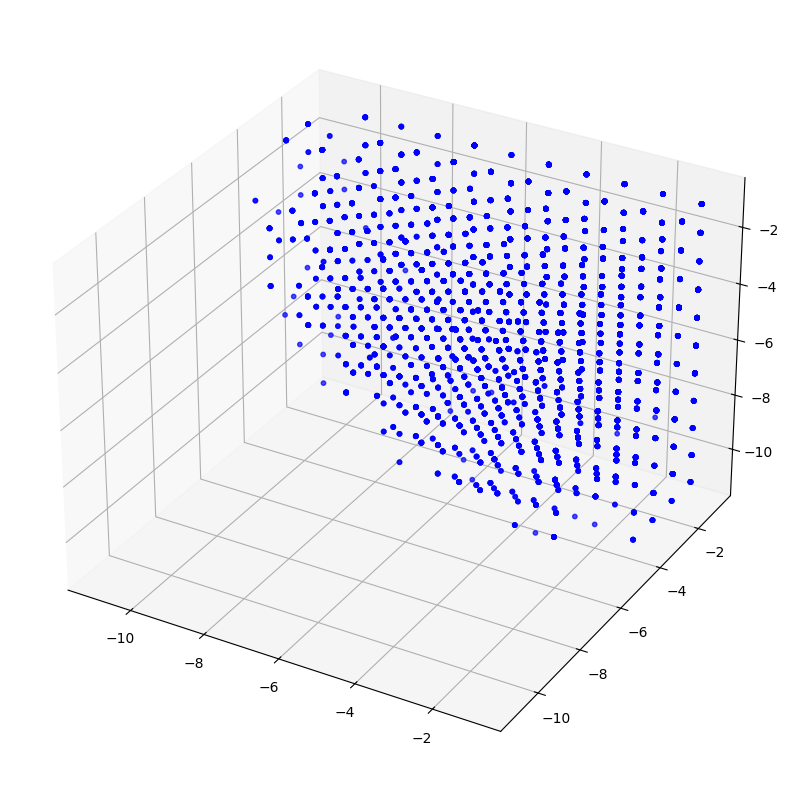

In [15]:
# =============================================
# 3D DEMO
# =============================================

# A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
# (
#     np.vstack([
#     # np.ones(dim),
#     np.eye(dim)
# ]))

A = np.eye(5)

w, k = sp.Symbol('w'), sp.Symbol('k')

symbols = [x, y, z, w, k]
mask = [x, y, z, w, k]
A_orig = A
A, mask_encode = mask_symbols(A, mask, symbols)
dim = A.shape[1]

b = np.zeros(A.shape[0], dtype=int)

u0 = np.array(np.ones(dim), dtype=int)
R = 12.0
print(A)
print(b)
print(u0)

sampler = ConeIHRSampler(A, b, R, u0, 1e6)

# TODO: I am not sure if those functions are valid
if is_cone_empty(A):
    print("No real solutions → no integer solutions")
# elif not cone_has_nonzero(A):
#     print("Only trivial point 0 is feasible → no gcd=1 integer solutions")
# elif not integer_feasible(A, R):
#     print("Cone exists but contains no integer point up to radius R")
else:
    print("Integer feasible → IHR can start safely!")


# sample 5000 points
at_most = 10000
samples = [next(sampler) for _ in range(at_most)]
samples = [tuple(reconstruct(s, mask_encode)) for s in samples]
print(len(samples))
as_set = set(samples)
print(len(as_set))
for sample in samples:
    if gcd_vec(sample) != 1:
        print(f'bad sample: {sample}')

# plot_3d_samples(samples, "IHR 3D integer sampling")
try:
    plot_3d_samples_with_hyperplanes(samples, A, b, R=R)
except Exception as e:
    print(e)
# TODO: maybe in order to ingore null trajectories check if all simple trajectories lie on HPs then no trajectory possible
#       Also, add timeout.

In [3]:
import math
import mpmath as mp  # pip install mpmath

def unit_ball_volume(d):
    # V_d = pi^{d/2} / Gamma(d/2 + 1)
    return mp.pi**(d/2) / mp.gamma(d/2 + 1)

def radius_for_N(N, d):
    Vd = unit_ball_volume(d)
    z = mp.zeta(d)
    R = (N * z / Vd) ** (1.0 / d)
    return math.ceil(R)

# example
N = 1e4 # for N samples with 1% dups we need M >= 50*N points in volume
# M = 50 * N
M = N
d = 11
R = radius_for_N(M, d)
print("Suggested R:", R)

Suggested R: 3


## Math utils

In [18]:
def gcd_vec(u):
    arr = np.abs(u.astype(int))
    nz = arr[arr != 0]
    if nz.size == 0:
        return 0
    return reduce(math.gcd, nz.tolist())

def reduce_system(A, zero_mask):
    """Return A_reduced and free_index list so you can map back."""
    mask = np.array(zero_mask, dtype=bool)
    keep = ~mask
    A_red = A[:, keep]
    free_idx = np.nonzero(keep)[0].tolist()
    return A_red, free_idx

class ContinuousHitAndRunSampler:
    def __init__(self, A, b, R, u0_full, zero_mask=None, eps_strict=1e-9,
                 burn_in=100, thinning=1, max_attempts_per_output=200,
                 rng=None):
        """
        A u <= b  (use b = zeros for Au <= 0), strictness is enforced via eps_strict: A u <= b - eps_strict
        u0_full: full-dim initial integer feasible vector (with zeros at fixed indices)
        zero_mask: boolean mask length d; True means this index is fixed to 0 and removed.
        """
        self.rng = rng or np.random.RandomState()
        self.A_full = np.array(A, dtype=float)
        self.b_full = np.array(b, dtype=float)
        self.R = float(R)
        self.eps = float(eps_strict)
        self.thinning = int(thinning)
        self.max_attempts_per_output = int(max_attempts_per_output)

        d = self.A_full.shape[1]
        if zero_mask is None:
            zero_mask = np.zeros(d, dtype=bool)
        self.zero_mask = np.array(zero_mask, dtype=bool)

        # reduce problem to free coordinates
        self.A, self.free_idx = reduce_system(self.A_full, self.zero_mask)
        self.b = self.b_full.copy() - self.eps  # enforce strict: A u <= b - eps

        # build initial reduced starting point
        u0_full = np.array(u0_full, dtype=int)
        self.u_full = u0_full.copy()
        # Map to reduced vector of floats
        self.u = self.u_full[self.free_idx].astype(float)
        self.dim = len(self.u)

        self.burn_in = int(burn_in)
        self._do_burnin()

    def _do_burnin(self):
        for _ in range(self.burn_in):
            self._single_step()

    def _single_step(self):
        # sample gaussian direction (continuous)
        d = self.rng.normal(size=self.dim)
        nd = np.linalg.norm(d)
        if nd == 0:
            return  # degenerate
        d = d / nd

        # compute real t-interval satisfying A (u + t d) <= b
        Ad = self.A.dot(d)
        Au = self.A.dot(self.u)

        t_min = -1e100
        t_max = 1e100

        # linear constraints
        for i in range(len(Ad)):
            a_dot_d = Ad[i]
            rhs = self.b[i] - Au[i]
            if abs(a_dot_d) < 1e-12:
                if rhs < 0:
                    # constraint violated for any t
                    return
                else:
                    continue
            t_bound = rhs / a_dot_d
            if a_dot_d > 0:
                t_max = min(t_max, t_bound)
            else:
                t_min = max(t_min, t_bound)
            if t_min > t_max:
                return

        # ball constraint ||u + t d||_inf <= R  (we'll use infinity norm box)
        # For simplicity use each coordinate bound
        for j in range(self.dim):
            dj = d[j]; uj = self.u[j]
            if abs(dj) < 1e-12:
                if abs(uj) > self.R:
                    return
                else:
                    continue
            # uj + t*dj in [-R, R] -> t in [(-R-uj)/dj, (R-uj)/dj]
            t1 = (-self.R - uj) / dj
            t2 = ( self.R - uj) / dj
            lo = min(t1,t2); hi = max(t1,t2)
            t_min = max(t_min, lo)
            t_max = min(t_max, hi)
            if t_min > t_max:
                return

        # Now pick t uniform in [t_min, t_max]
        if not (t_min <= t_max):
            return
        t = self.rng.uniform(t_min, t_max)

        u_cont = self.u + t * d
        # round to nearest integer vector in reduced coordinates
        z_red = np.rint(u_cont).astype(int)

        # reconstruct full vector
        z_full = np.zeros(self.A_full.shape[1], dtype=int)
        z_full[self.free_idx] = z_red
        # fixed coords are zero by mask (already zero)

        # check integer feasibility: strict inequalities A_full z_full < b_full
        if np.any(self.A_full.dot(z_full) > (self.b_full - 1e-12)):
            # candidate out of strict feasible region
            return

        # check box radius on full vector
        if np.max(np.abs(z_full)) > self.R:
            return

        # gcd check
        if gcd_vec(z_full) != 1:
            return

        # accept: update reduced continuous state to z_red as float
        self.u = z_red.astype(float)
        self.u_full = z_full

    def __iter__(self):
        return self

    def __next__(self):
        # generate one output after thinning attempts
        attempts = 0
        while True:
            # do multiple internal steps and then return one sample (thinning)
            for _ in range(self.thinning):
                # try up to max_attempts_per_output times to move
                for _ in range(self.max_attempts_per_output):
                    self._single_step()
                # if no move succeeded we still continue; it's fine
            attempts += 1
            # yield current integer vector
            return self.u_full.copy()

In [23]:
A = np.eye(5)

w, k = sp.Symbol('w'), sp.Symbol('k')

symbols = [x, y, z, w, k]
mask = [x, y, z, w, k]
A_orig = A
A, mask_encode = mask_symbols(A, mask, symbols)
dim = A.shape[1]

b = np.zeros(A.shape[0], dtype=int)

u0 = np.array(np.ones(dim), dtype=int)
R = 12.0
print(A)
print(b)
print(u0)

sampler = ContinuousHitAndRunSampler(A, b, R, u0, thinning=2, burn_in=200, max_attempts_per_output=50)

# TODO: I am not sure if those functions are valid
if is_cone_empty(A):
    print("No real solutions → no integer solutions")
# elif not cone_has_nonzero(A):
#     print("Only trivial point 0 is feasible → no gcd=1 integer solutions")
# elif not integer_feasible(A, R):
#     print("Cone exists but contains no integer point up to radius R")
else:
    print("Integer feasible → IHR can start safely!")


# sample 5000 points
at_most = 10000
samples = [next(sampler) for _ in range(at_most)]
samples = [tuple(reconstruct(s, mask_encode)) for s in samples]
print(len(samples))
as_set = set(samples)
print(len(as_set))
for sample in samples:
    if gcd_vec(sample) != 1:
        print(f'bad sample: {sample}')

# plot_3d_samples(samples, "IHR 3D integer sampling")
try:
    plot_3d_samples_with_hyperplanes(samples, A, b, R=R)
except Exception as e:
    print(e)

bad bad
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[0 0 0 0 0]
[1 1 1 1 1]
Integer feasible → IHR can start safely!
10000
9788


AttributeError: 'tuple' object has no attribute 'astype'

In [2]:
# filename: cone_samplers.py
import numpy as np
import math
import time
from functools import reduce
from numba import njit, prange

# -----------------------
# Numba helpers
# -----------------------

@njit
def gcd_vec_numba(u):
    # u is int64 1D array
    g = 0
    for i in range(u.shape[0]):
        v = u[i]
        if v < 0:
            v = -v
        g = math.gcd(g, v)
    return g

@njit
def check_Au_le_b(A, u, b):
    # returns True if A @ u <= b elementwise
    m, n = A.shape
    for i in range(m):
        s = 0.0
        for j in range(n):
            s += A[i, j] * u[j]
        if s > b[i]:
            return False
    return True

@njit
def check_Au_lt_b_e(A, u, b, eps):
    # strict inequality Au < b using eps: check A u <= b - eps
    m, n = A.shape
    for i in range(m):
        s = 0.0
        for j in range(n):
            s += A[i, j] * u[j]
        if s > b[i] - eps:
            return False
    return True

@njit
def sample_unit_normalized_direction(rng_state, d):
    """
    Produce a normalized Gaussian direction vector (float64).
    rng_state: a 1-element array used as rng seed state in Numba since np.random isn't available inside njit easily.
    We'll use Box-Muller style via Python generator (we won't call this inside large parallel code).
    NOTE: We do not attempt to produce a RNG inside njit for simplicity here.
    """
    # Placeholder: actual direction sampling done outside in Python using numpy for better RNG
    return np.zeros(d)

# -----------------------
# Python helpers (not numba)
# -----------------------

def gcd_vec(u):
    arr = np.abs(np.array(u, dtype=np.int64))
    nz = arr[arr != 0]
    if nz.size == 0:
        return 0
    return reduce(math.gcd, nz.tolist())

def reduce_system(A, zero_mask):
    mask = np.array(zero_mask, dtype=bool)
    keep = ~mask
    A_red = A[:, keep]
    free_idx = np.nonzero(keep)[0].tolist()
    return A_red, free_idx
# Compare methods
# 1. MCMC - HR
# 2. Layered shell + rounding

SyntaxError: invalid syntax (1774793634.py, line 76)

### Numba things

In [25]:
# filename: cone_samplers.py
import numpy as np
import math
import time
from functools import reduce
from numba import njit, prange

# -----------------------
# Numba helpers
# -----------------------

@njit
def gcd_vec_numba(u):
    # u is int64 1D array
    g = 0
    for i in range(u.shape[0]):
        v = u[i]
        if v < 0:
            v = -v
        g = math.gcd(g, v)
    return g

@njit
def check_Au_le_b(A, u, b):
    # returns True if A @ u <= b elementwise
    m, n = A.shape
    for i in range(m):
        s = 0.0
        for j in range(n):
            s += A[i, j] * u[j]
        if s > b[i]:
            return False
    return True

@njit
def check_Au_lt_b_e(A, u, b, eps):
    # strict inequality Au < b using eps: check A u <= b - eps
    m, n = A.shape
    for i in range(m):
        s = 0.0
        for j in range(n):
            s += A[i, j] * u[j]
        if s > b[i] - eps:
            return False
    return True

@njit
def sample_unit_normalized_direction(rng_state, d):
    """
    Produce a normalized Gaussian direction vector (float64).
    rng_state: a 1-element array used as rng seed state in Numba since np.random isn't available inside njit easily.
    We'll use Box-Muller style via Python generator (we won't call this inside large parallel code).
    NOTE: We do not attempt to produce a RNG inside njit for simplicity here.
    """
    # Placeholder: actual direction sampling done outside in Python using numpy for better RNG
    return np.zeros(d)

# -----------------------
# Python helpers (not numba)
# -----------------------

def gcd_vec(u):
    arr = np.abs(np.array(u, dtype=np.int64))
    nz = arr[arr != 0]
    if nz.size == 0:
        return 0
    return reduce(math.gcd, nz.tolist())

def reduce_system(A, zero_mask):
    mask = np.array(zero_mask, dtype=bool)
    keep = ~mask
    A_red = A[:, keep]
    free_idx = np.nonzero(keep)[0].tolist()
    return A_red, free_idx


### MCMC HR implementation

In [26]:
# -----------------------
# Continuous Hit-and-Run + rounding sampler
# -----------------------

@njit
def compute_t_interval_numba(A, u, dvec, R):
    """
    Compute real interval [tmin, tmax] s.t. A (u + t d) <= b  and |u + t d|_inf <= R.
    Here b is assumed to be 0 vector for reduced system; we'll feed A and b externally.
    We'll return (t_min, t_max) as float. If empty, return (1.0, 0.0)
    Note: this generic function assumes inequality A(u+td) <= 0; caller may shift b externally.
    """
    m, n = A.shape
    tmin = -1e100
    tmax = 1e100
    # cone constraints A(u+t d) <= 0
    for i in range(m):
        a_dot_d = 0.0
        a_dot_u = 0.0
        for j in range(n):
            a_dot_d += A[i, j] * dvec[j]
            a_dot_u += A[i, j] * u[j]
        rhs = -a_dot_u  # want a_dot_d * t <= rhs
        if abs(a_dot_d) < 1e-12:
            if rhs < 0:
                return 1.0, 0.0
            else:
                continue
        if a_dot_d > 0:
            # t <= floor(rhs / a_dot_d) but we're real: t <= rhs / a_dot_d
            tmax = min(tmax, rhs / a_dot_d)
        else:
            tmin = max(tmin, rhs / a_dot_d)
        if tmin > tmax:
            return 1.0, 0.0
    # box constraints |u_j + t d_j| <= R  (infty-norm)
    for j in range(n):
        dj = dvec[j]
        uj = u[j]
        if abs(dj) < 1e-12:
            if abs(uj) > R:
                return 1.0, 0.0
            else:
                continue
        t1 = (-R - uj) / dj
        t2 = ( R - uj) / dj
        lo = t1 if t1 < t2 else t2
        hi = t2 if t2 > t1 else t1
        if lo > tmin:
            tmin = lo
        if hi < tmax:
            tmax = hi
        if tmin > tmax:
            return 1.0, 0.0
    return tmin, tmax

class ContinuousHRSampler:
    """
    Continuous Hit-and-Run in reduced space (free coords only), then round to integer and accept if integer feasible and gcd=1.
    Numba is used for the inner t-interval computation and checks where possible.
    """
    def __init__(self, A, b, R, u0_full, zero_mask=None, eps_strict=1e-9,
                 burn_in=200, thinning=1, rng=None, max_attempts_per_step=200):
        self.A_full = np.array(A, dtype=float)
        self.b_full = np.array(b, dtype=float)
        self.R = float(R)
        self.eps = float(eps_strict)
        self.rng = np.random.RandomState() if rng is None else rng
        d = self.A_full.shape[1]
        if zero_mask is None:
            zero_mask = np.zeros(d, dtype=bool)
        self.zero_mask = np.array(zero_mask, dtype=bool)
        self.free_idx = np.nonzero(~self.zero_mask)[0]
        self.A = self.A_full[:, self.free_idx]
        self.b = self.b_full.copy()
        # starting reduced vector
        u0_full = np.array(u0_full, dtype=np.int64)
        self.u_full = u0_full.copy()
        self.u = self.u_full[self.free_idx].astype(np.float64)
        self.dim = len(self.u)
        self.burn_in = int(burn_in)
        self.thinning = int(thinning)
        self.max_attempts_per_step = int(max_attempts_per_step)
        # perform burn-in
        for _ in range(self.burn_in):
            self._single_step()

    def _single_step(self):
        # sample continuous Gaussian direction
        d = self.rng.normal(size=self.dim)
        norm = np.linalg.norm(d)
        if norm == 0.0:
            return False
        d = d / norm
        # compute t interval using numba function - we pass A and u etc.
        tmin, tmax = compute_t_interval_numba(self.A, self.u, d, self.R)
        if tmin > tmax:
            return False
        # sample t uniformly in [tmin, tmax]
        t = self.rng.uniform(tmin, tmax)
        u_cont = self.u + t * d
        # round to nearest integer
        z_red = np.rint(u_cont).astype(np.int64)
        # reconstruct full vector
        z_full = np.zeros(self.A_full.shape[1], dtype=np.int64)
        z_full[self.free_idx] = z_red
        # integer strictness check: A_full @ z_full <= b_full - eps
        if not check_Au_lt_b_e(self.A_full, z_full, self.b_full, self.eps):
            return False
        if np.max(np.abs(z_full)) > self.R + 1e-9:
            return False
        if gcd_vec_numba(z_full) != 1:
            return False
        # accept
        self.u = z_red.astype(np.float64)
        self.u_full = z_full
        return True

    def sample(self, n_samples, max_total_attempts=10**7):
        out = np.empty((n_samples, self.A_full.shape[1]), dtype=np.int64)
        produced = 0
        total_attempts = 0
        t0 = time.perf_counter()
        while produced < n_samples and total_attempts < max_total_attempts:
            # try to move at least once
            moved = False
            for _ in range(self.max_attempts_per_step):
                total_attempts += 1
                if self._single_step():
                    moved = True
                    break
            # thinning: do thinning-1 more steps without accepting
            for _t in range(self.thinning - 1):
                for _ in range(self.max_attempts_per_step):
                    total_attempts += 1
                    self._single_step()
            # yield current state
            out[produced, :] = self.u_full.copy()
            produced += 1
        t1 = time.perf_counter()
        stats = {"time_sec": t1 - t0, "total_attempts": total_attempts}
        return out[:produced], stats


### Layered shell sampler

In [27]:

# -----------------------
# Layered / Shell + rounding sampler
# -----------------------

class LayeredShellSampler:
    """
    Draw continuous (r, direction) uniformly in cone volume, round to nearest integer, accept if integer satisfies Au < b and gcd=1.
    - A, b are numpy arrays (m x d) and (m,) such that Au <= b defines the (closed) cone; we will enforce strictness with eps_strict.
    - R: infinity-norm or L2 radius bounding the region (we use L2 sphere radius here).
    - zero_mask: boolean mask for coordinates fixed to 0 (True = fixed to 0). Those coords are not sampled and remain 0.
    """
    def __init__(self, A, b, R, zero_mask=None, eps_strict=1e-9, rng=None):
        self.A_full = np.array(A, dtype=float)
        self.b_full = np.array(b, dtype=float)
        self.d = self.A_full.shape[1]
        if zero_mask is None:
            zero_mask = np.zeros(self.d, dtype=bool)
        self.zero_mask = np.array(zero_mask, dtype=bool)
        self.free_idx = np.nonzero(~self.zero_mask)[0]
        self.A = self.A_full[:, self.free_idx]
        self.b = self.b_full.copy()
        self.R = float(R)
        self.eps = float(eps_strict)
        self.rng = np.random.RandomState() if rng is None else rng

        # quick pre-check: sample some directions to estimate acceptance probability
        # Not strictly necessary.

    def sample_direction_in_cone(self):
        """
        Sample direction uniformly on unit sphere and accept if direction points into cone:
        direction v must satisfy A v <= -eps (so ray from origin stays interior).
        We use rejection sampling on sphere.
        """
        tries = 0
        while True:
            v = self.rng.normal(size=self.A.shape[1])
            n = np.linalg.norm(v)
            if n == 0:
                continue
            v = v / n
            # check direction inside cone: A @ (v) <= 0 (we require strictness later)
            if np.all(self.A.dot(v) <= -self.eps):
                return v
            tries += 1
            if tries % 1000 == 0:
                # fallback: relax epsilon slightly if acceptance too low
                # (But we don't change eps stored; just relax temporarily)
                if np.all(self.A.dot(v) <= 1e-6):
                    return v

    def draw_one(self, max_attempts=2000):
        """
        Attempt to draw one integer sample by:
         - sample radius r ~ Uniform in volume -> r = R * U^(1/d)
         - sample direction uniformly in cone
         - form continuous point u_cont = r * v in reduced coordinates
         - round to nearest integer for free coords, reconstruct full vector with zeros
         - check integer strictness and gcd
        Returns (u_full as int array) or None if failed after attempts.
        """
        dfree = len(self.free_idx)
        for attempt in range(max_attempts):
            # sample radius for uniform in volume:
            u = self.rng.rand()
            r = self.R * (u ** (1.0 / dfree)) if dfree > 0 else 0.0
            # sample direction in cone
            v = self.sample_direction_in_cone()
            u_cont = r * v
            # round to integer
            z_red = np.rint(u_cont).astype(np.int64)
            # build full vector
            z_full = np.zeros(self.d, dtype=np.int64)
            z_full[self.free_idx] = z_red
            # check strict inequalities Au < b -> we use <= b - 1e-9 or integer margin -1
            # For integer strictness we recommend using integer margin like b-1 if A,b integer.
            if not check_Au_lt_b_e(self.A_full, z_full, self.b_full, self.eps):
                continue
            if np.max(np.abs(z_full)) > self.R + 1e-9:
                continue
            if gcd_vec_numba(z_full) != 1:
                continue
            return z_full
        return None

    def sample(self, n_samples, max_attempts_per=2000):
        out = np.empty((n_samples, self.d), dtype=np.int64)
        tries = 0
        accepted = 0
        t0 = time.perf_counter()
        while accepted < n_samples:
            tries += 1
            z = self.draw_one(max_attempts=max_attempts_per)
            if z is None:
                # can choose to increase attempts or break
                # we'll keep trying
                continue
            out[accepted, :] = z
            accepted += 1
        t1 = time.perf_counter()
        stats = {"attempts_total": tries, "time_sec": t1 - t0}
        return out, stats


# -----------------------
# Utility: stats on samples
# -----------------------

def sample_stats(samples):
    """
    samples: ndarray (N, d) int
    returns dict with unique_count, duplicate_rate, fraction_changed_steps, some autocorrelation estimate for coordinates
    """
    N, d = samples.shape
    seen = set()
    unique = 0
    for i in range(N):
        key = tuple(samples[i].tolist())
        if key not in seen:
            seen.add(key)
            unique += 1
    duplicate_count = N - unique
    dup_rate = duplicate_count / N
    # fraction of steps that changed
    changes = 0
    for i in range(1, N):
        if not np.array_equal(samples[i], samples[i-1]):
            changes += 1
    frac_changed = changes / (N - 1) if N > 1 else 0.0
    return {"N": N, "unique": unique, "duplicates": duplicate_count,
            "dup_rate": dup_rate, "frac_changed": frac_changed}


In [31]:
# Example cone: u_i <= -1 for all i  (strict negative orthant)
d = 5
A = np.vstack([np.eye(d)]) * 1.0  # Ai_j = delta_ij
b = -1.0 * np.ones(d)            # ui <= -1  (so Au <= b)
R = 11

# no zero_mask
zero_mask = np.zeros(d, dtype=bool)

# find an integer feasible starting point quickly using simple search (or use ILP)
# trivial in this toy case:
u0 = -np.ones(d, dtype=int)

# Layered sampler test
layered = LayeredShellSampler(A, b, R, zero_mask=zero_mask, eps_strict=1e-9)
S, stats = layered.sample(1000, max_attempts_per=2000)
print("Layered stats:", stats)
print(sample_stats(S))

# Continuous HR sampler test
hr = ContinuousHRSampler(A, b, R, u0_full=u0, zero_mask=zero_mask,
                         eps_strict=1e-9, burn_in=200, thinning=2, max_attempts_per_step=200)
S2, stats2 = hr.sample(1000)
print("HR stats:", stats2)
print(sample_stats(S2))

Layered stats: {'attempts_total': 1000, 'time_sec': 1.4307568999938667}
{'N': 1000, 'unique': 923, 'duplicates': 77, 'dup_rate': 0.077, 'frac_changed': 0.998998998998999}
HR stats: {'time_sec': 3.029145900014555, 'total_attempts': 201356}
{'N': 1000, 'unique': 995, 'duplicates': 5, 'dup_rate': 0.005, 'frac_changed': 1.0}


In [32]:
# filename: cone_numba_samplers.py
import numpy as np
import time
from numba import njit
from functools import reduce
import math

# -------------------------
# Numba-compiled helpers
# -------------------------

@njit
def gcd_vec_numba(arr):
    """GCD of int64 array (absolute values)."""
    g = 0
    for i in range(arr.shape[0]):
        v = arr[i]
        if v < 0:
            v = -v
        g = math.gcd(g, v)
    return g

@njit
def check_Au_strict_numba(A, b, u, eps):
    """Return True if A @ u <= b - eps (strict with eps margin)."""
    m, n = A.shape
    for i in range(m):
        s = 0.0
        for j in range(n):
            s += A[i, j] * u[j]
        if s > b[i] - eps:
            return False
    return True

@njit
def reconstruct_full_and_check(A_full, b_full, free_idx, z_red, R, eps):
    """
    Build z_full from z_red and free_idx (free_idx are indices kept),
    check strict inequalities on full system and box radius and gcd==1.
    Returns (ok, z_full_array)
    """
    d_full = A_full.shape[1]
    z_full = np.zeros(d_full, dtype=np.int64)
    # fill free coordinates
    for k in range(z_red.shape[0]):
        idx = free_idx[k]
        z_full[idx] = z_red[k]
    # strict check
    if not check_Au_strict_numba(A_full, b_full, z_full, eps):
        return False, z_full
    # radius check (infty-norm)
    maxabs = 0
    for i in range(d_full):
        av = z_full[i]
        if av < 0:
            av = -av
        if av > maxabs:
            maxabs = av
    if maxabs > R + 1e-12:
        return False, z_full
    # gcd check
    if gcd_vec_numba(z_full) != 1:
        return False, z_full
    return True, z_full

# -------------------------
# Layered-shell njit worker
# -------------------------
@njit
def layered_sampler_worker(A_full, b_full, free_idx, R, eps,
                           radii, dirs, jitters, stability_thresh,
                           out_buffer, max_out):
    """
    Attempt to produce up to max_out integer samples.
    Inputs:
      - radii: (Nbatch,) floats in (0, R]
      - dirs: (Nbatch, d_free) floats, unit vectors
      - jitters: (Nbatch,) floats (jitter magnitude)
      - stability_thresh: float, we reject if any coordinate fractional part is within threshold of 0.5
    Returns: number_accepted (int), out_buffer filled with accepted samples (shape (max_out, d_full))
    """
    produced = 0
    Nbatch = radii.shape[0]
    d_free = dirs.shape[1]
    d_full = A_full.shape[1]

    for it in range(Nbatch):
        if produced >= max_out:
            break
        # continuous point
        r = radii[it]
        v = dirs[it]
        # apply radius and jitter
        eps_j = jitters[it]
        # perturbation vector: use v scaled by eps_j (directional jitter)
        # (we don't have an orthogonal small random vector available here; using v scaled is simple and symmetric)
        # build continuous reduced vector
        ucont = np.empty(d_free, dtype=np.float64)
        for j in range(d_free):
            ucont[j] = r * v[j] + eps_j * v[j]
        # rounding - but check rounding stability: fractional parts near .5 are unstable
        z_red = np.empty(d_free, dtype=np.int64)
        unstable = False
        for j in range(d_free):
            val = ucont[j]
            rounded = math.floor(val + 0.5)
            frac = val - math.floor(val)
            # distance to 0.5:
            if abs(frac - 0.5) < stability_thresh:
                unstable = True
                break
            z_red[j] = np.int64(rounded)
        if unstable:
            continue
        # reconstruct full vector and check constraints
        ok, z_full = reconstruct_full_and_check(A_full, b_full, free_idx, z_red, R, eps)
        if ok:
            # write to out_buffer
            for jj in range(d_full):
                out_buffer[produced, jj] = z_full[jj]
            produced += 1

    return produced

# -------------------------
# Continuous HR njit helpers
# -------------------------
@njit
def compute_t_interval_numba(A, u, dvec, R):
    """
    Compute t interval [tmin, tmax] (real) s.t. A(u + t d) <= 0 and infty-norm <= R.
    Returns (tmin, tmax). If infeasible returns (1.0, 0.0).
    """
    m, n = A.shape
    tmin = -1e100
    tmax = 1e100
    # A(u + t d) <= 0 -> (A d) t <= -A u
    for i in range(m):
        a_dot_d = 0.0
        a_dot_u = 0.0
        for j in range(n):
            a_dot_d += A[i, j] * dvec[j]
            a_dot_u += A[i, j] * u[j]
        rhs = -a_dot_u
        if abs(a_dot_d) < 1e-12:
            if rhs < 0:
                return 1.0, 0.0
            else:
                continue
        if a_dot_d > 0:
            tmax = tmax if tmax < rhs / a_dot_d else rhs / a_dot_d
        else:
            # a_dot_d < 0
            tmin = tmin if tmin > rhs / a_dot_d else rhs / a_dot_d
        if tmin > tmax:
            return 1.0, 0.0
    # box constraints |u_j + t d_j| <= R
    for j in range(n):
        dj = dvec[j]
        uj = u[j]
        if abs(dj) < 1e-12:
            if abs(uj) > R:
                return 1.0, 0.0
            else:
                continue
        t1 = (-R - uj) / dj
        t2 = ( R - uj) / dj
        lo = t1 if t1 < t2 else t2
        hi = t2 if t2 > t1 else t1
        if lo > tmin:
            tmin = lo
        if hi < tmax:
            tmax = hi
        if tmin > tmax:
            return 1.0, 0.0
    return tmin, tmax

@njit
def hr_worker_step(A_full, b_full, free_idx, u_red, dvec, tval, R, eps):
    """
    Given a candidate direction dvec (unit) and real tval, attempt to accept a rounded integer point:
    - u_red is current reduced integer location as float array
    - compute u_cont = u_red + tval * dvec
    - round -> z_red
    - reconstruct and check strict inequalities + gcd
    Return (accepted_bool, z_full_array)
    """
    n = u_red.shape[0]
    # continuous point
    ucont = np.empty(n, dtype=np.float64)
    for i in range(n):
        ucont[i] = u_red[i] + tval * dvec[i]
    # round
    z_red = np.empty(n, dtype=np.int64)
    for i in range(n):
        z_red[i] = np.int64(math.floor(ucont[i] + 0.5))
    # reconstruct and check
    ok, z_full = reconstruct_full_and_check(A_full, b_full, free_idx, z_red, R, eps)
    return ok, z_full

# -------------------------
# Python classes
# -------------------------

    class LayeredShellNumba:
        def __init__(self, A_full, b_full, R, zero_mask=None,
                     eps_strict=1e-9, jitter_scale=0.02, stability_thresh=0.03,
                     batch_size=16384, rng=None):
            """
            A_full: (m x d) numpy array
            b_full: (m,) numpy array
            R: radius (L2)
            zero_mask: boolean mask length d (True means coordinate fixed to 0)
            jitter_scale: small additive jitter magnitude (applied along direction)
            stability_thresh: fractional distance to 0.5 to reject unstable rounding
            batch_size: number of random candidates generated per call to worker
            """
            self.A_full = np.array(A_full, dtype=np.float64)
            self.b_full = np.array(b_full, dtype=np.float64)
            self.R = float(R)
            d = self.A_full.shape[1]
            if zero_mask is None:
                zero_mask = np.zeros(d, dtype=bool)
            self.zero_mask = np.array(zero_mask, dtype=bool)
            self.free_idx = np.nonzero(~self.zero_mask)[0].astype(np.int64)
            self.d_free = len(self.free_idx)
            self.eps = float(eps_strict)
            self.jitter_scale = float(jitter_scale)
            self.stability_thresh = float(stability_thresh)
            self.batch_size = int(batch_size)
            self.rng = np.random.RandomState() if rng is None else rng

        def _generate_batch_randoms(self):
            N = self.batch_size
            if self.d_free == 0:
                # trivial zero vector
                radii = np.zeros(N, dtype=np.float64)
                dirs = np.zeros((N, 0), dtype=np.float64)
                jitters = np.zeros(N, dtype=np.float64)
                return radii, dirs, jitters
            # radii for uniform in volume: r = R * U^(1/d)
            u = self.rng.random(size=N)
            radii = (u ** (1.0 / self.d_free)) * self.R
            # sample normals and normalize to unit vectors
            raw = self.rng.normal(size=(N, self.d_free))
            norms = np.sqrt((raw * raw).sum(axis=1))
            # avoid zero norms
            norms[norms == 0] = 1.0
            dirs = raw / norms[:, None]
            # jitters: small magnitude signed (could be zero sometimes)
            jitters = self.rng.normal(scale=self.jitter_scale, size=N)
            return radii.astype(np.float64), dirs.astype(np.float64), jitters.astype(np.float64)

        def sample(self, n_samples, max_rounds_factor=10):
            out = np.empty((n_samples, self.A_full.shape[1]), dtype=np.int64)
            produced = 0
            attempts = 0
            t0 = time.perf_counter()
            # we'll loop generating random batches and pass to njit worker
            while produced < n_samples:
                radii, dirs, jitters = self._generate_batch_randoms()
                # call njit worker -- it will attempt up to batch_size accepts
                buf = np.empty((self.batch_size, self.A_full.shape[1]), dtype=np.int64)
                got = layered_sampler_worker(self.A_full, self.b_full, self.free_idx, self.R, self.eps,
                                             radii, dirs, jitters, self.stability_thresh,
                                             buf, min(self.batch_size, n_samples - produced))
                attempts += self.batch_size
                if got > 0:
                    out[produced:produced+got, :] = buf[:got, :]
                    produced += got
            t1 = time.perf_counter()
            stats = {"time_sec": t1 - t0, "attempts_random_draws": attempts}
            return out, stats

class ContinuousHRNumba:
    def __init__(self, A_full, b_full, R, u0_full, zero_mask=None,
                 eps_strict=1e-9, burn_in=200, thinning=1,
                 max_attempts_per_step=200, batch_dirs=4096, rng=None):
        self.A_full = np.array(A_full, dtype=np.float64)
        self.b_full = np.array(b_full, dtype=np.float64)
        self.R = float(R)
        d = self.A_full.shape[1]
        if zero_mask is None:
            zero_mask = np.zeros(d, dtype=bool)
        self.zero_mask = np.array(zero_mask, dtype=bool)
        self.free_idx = np.nonzero(~self.zero_mask)[0].astype(np.int64)
        self.d_free = len(self.free_idx)
        self.eps = float(eps_strict)
        self.thinning = int(thinning)
        self.max_attempts_per_step = int(max_attempts_per_step)
        self.batch_dirs = int(batch_dirs)
        self.rng = np.random.RandomState() if rng is None else rng

        # reduced starting u
        u0_full = np.array(u0_full, dtype=np.int64)
        self.u_full = u0_full.copy()
        self.u_red = self.u_full[self.free_idx].astype(np.float64)
        # burn-in
        for _ in range(burn_in):
            self._try_step_once()

    def _try_step_once(self):
        if self.d_free == 0:
            return False
        # sample a real Gaussian direction and normalize
        dvec = self.rng.normal(size=self.d_free)
        nd = np.linalg.norm(dvec)
        if nd == 0:
            return False
        dvec = dvec / nd
        # compute t interval (numba can't be called with python arrays inside _try_step unless we copy)
        tmin, tmax = compute_t_interval_numba(self.A_full[:, self.free_idx], self.u_red, dvec, self.R)
        if tmin > tmax:
            return False
        # uniform t in [tmin, tmax]
        tval = self.rng.uniform(tmin, tmax)
        ok, z_full = hr_worker_step(self.A_full, self.b_full, self.free_idx, self.u_red, dvec, tval, self.R, self.eps)
        if ok:
            # accept and move
            self.u_full = z_full
            self.u_red = self.u_full[self.free_idx].astype(np.float64)
            return True
        return False

    def sample(self, n_samples, max_total_attempts=10**7):
        out = np.empty((n_samples, self.A_full.shape[1]), dtype=np.int64)
        produced = 0
        total_attempts = 0
        t0 = time.perf_counter()
        while produced < n_samples and total_attempts < max_total_attempts:
            moved = False
            # try to make one accepted step
            for _ in range(self.max_attempts_per_step):
                total_attempts += 1
                if self._try_step_once():
                    moved = True
                    break
            # thinning: perform thinning-1 additional steps (attempted) but we don't require acceptance
            for _ in range(self.thinning - 1):
                for _ in range(self.max_attempts_per_step):
                    total_attempts += 1
                    self._try_step_once()
            # record current state as sample (even if did not move)
            out[produced, :] = self.u_full.copy()
            produced += 1
        t1 = time.perf_counter()
        stats = {"time_sec": t1 - t0, "total_attempts": total_attempts}
        return out[:produced, :], stats

# -------------------------
# Utility stats
# -------------------------
def sample_stats(samples):
    N, d = samples.shape
    seen = set()
    unique = 0
    for i in range(N):
        key = tuple(int(x) for x in samples[i])
        if key not in seen:
            seen.add(key)
            unique += 1
    duplicates = N - unique
    dup_rate = duplicates / N
    # fraction changed
    changes = 0
    for i in range(1, N):
        if not np.array_equal(samples[i], samples[i-1]):
            changes += 1
    frac_changed = changes / (N - 1) if N > 1 else 0.0
    return {"N": N, "unique": unique, "duplicates": duplicates, "dup_rate": dup_rate, "frac_changed": frac_changed}


In [42]:
if __name__ == "__main__":
    import numpy as np

    # toy cone example in d=5: negative orthant with strictness (u_i <= -1)
    d = 5
    A = np.vstack([np.eye(d)])          # Ai_j = delta_ij
    b = -1.0 * np.ones(d)               # ui <= -1  -> strict interior
    R = 10

    # find trivial start (all -1)
    u0 = -np.ones(d, dtype=int)

    # Layered improved sampler
    layered = LayeredShellNumba(A, b, R, zero_mask=None, eps_strict=1e-9,
                                jitter_scale=0.03, stability_thresh=0.03, batch_size=8192)
    S_layered, stats_layered = layered.sample(5000)
    print("Layered time:", stats_layered, sample_stats(S_layered))

    # Continuous HR sampler
    hr = ContinuousHRNumba(A, b, R, u0_full=u0, zero_mask=None,
                           eps_strict=1e-9, burn_in=200, thinning=2, max_attempts_per_step=200)
    S_hr, stats_hr = hr.sample(5000)
    print("HR time:", stats_hr, sample_stats(S_hr))


Layered time: {'time_sec': 4.962031900009606, 'attempts_random_draws': 1335296} {'N': 5000, 'unique': 2487, 'duplicates': 2513, 'dup_rate': 0.5026, 'frac_changed': 1.0}
HR time: {'time_sec': 30.76386460001231, 'total_attempts': 1007039} {'N': 5000, 'unique': 4764, 'duplicates': 236, 'dup_rate': 0.0472, 'frac_changed': 1.0}


In [90]:
import math

def compute_radius_for_duplicates(k, d, dup_frac=0.01, safety_factor=1.05):
    """
    Compute radius R so that expected duplicate fraction <= dup_frac
    for k samples in dimension d (approx).
    Returns (R_float, R_ceil).
    """
    # required distinct M
    M_req = k / (2.0 * dup_frac)

    # try scipy for gamma and zeta
    try:
        from scipy.special import gamma, zeta
        Vd = math.pi**(d/2) / float(gamma(d/2 + 1))
        z = float(zeta(d))
    except Exception:
        import mpmath as mp
        Vd = float(mp.pi**(d/2) / mp.gamma(d/2 + 1))
        z = float(mp.zeta(d))

    R = (M_req * z / Vd) ** (1.0 / d)
    R *= safety_factor
    return R, math.ceil(R)

# Example:
k = 60
d = 2
R_float, R_int = compute_radius_for_duplicates(k, d, dup_frac=0.01, safety_factor=1.05)
print("Suggested R (float):", R_float, "R ceil:", R_int, 'recommended', int(R_int * 1.1))


Suggested R (float): 41.61493662486312 R ceil: 42 recommended 46


# Gemini

In [61]:
import numpy as np
import time
from numba import njit, float64, int64, boolean

# --- Shared Numba Logic ---

@njit(cache=True)
def gcd_recursive(a, b):
    while b:
        a, b = b, a % b
    return a

@njit(cache=True)
def get_gcd_of_array(arr):
    """Calculates GCD of a vector. Returns 1 immediately if any pair gives 1."""
    d = len(arr)
    if d == 0: return 0
    result = abs(arr[0])
    for i in range(1, d):
        result = gcd_recursive(result, abs(arr[i]))
        if result == 1:
            return 1
    return result

@njit(cache=True)
def is_valid_integer_point(point, A, b, R_sq):
    """
    Checks 3 conditions:
    1. Inside Radius (L2)
    2. Inside Cone (Ax <= b)
    3. GCD == 1
    """
    # 1. Radius Check
    norm_sq = 0.0
    for x in point:
        norm_sq += x*x
    if norm_sq > R_sq or norm_sq == 0: # Exclude origin
        return False

    # 2. Cone Check (Ax <= b)
    # Manual dot product for speed
    m, d = A.shape
    for i in range(m):
        dot = 0.0
        for j in range(d):
            dot += A[i, j] * point[j]
        if dot > b[i]:
            return False

    # 3. GCD Check (Primitive)
    if get_gcd_of_array(point) != 1:
        return False

    return True

In [62]:
@njit(cache=True)
def layered_worker_optimized(A, b, R_sq, radii, dirs, jitters, out_buf):
    """
    Numba worker for rejection sampling.
    """
    N = len(radii)
    d = dirs.shape[1]
    count = 0

    for i in range(N):
        # We build the candidate integer point directly
        # P_candidate = Round( radius * direction + spatial_jitter )

        # We use a temporary array to hold the integer candidate
        # to avoid modifying out_buf unless it's valid
        is_valid = True

        # --- 1. Construct & Check Radius Early ---
        # We calculate norm_sq on the fly to fail fast if rounding pushes it out
        cand_norm_sq = 0.0

        for k in range(d):
            val = dirs[i, k] * radii[i] + jitters[i, k]
            val_int = int(round(val))
            out_buf[count, k] = val_int
            cand_norm_sq += val_int * val_int

        if cand_norm_sq > R_sq or cand_norm_sq == 0:
            continue # Skip to next sample

        # --- 2. Check Linear Constraints (Ax <= b) ---
        m = A.shape[0]
        for row in range(m):
            dot = 0.0
            for col in range(d):
                dot += A[row, col] * out_buf[count, col]
            if dot > b[row]:
                is_valid = False
                break
        if not is_valid: continue

        # --- 3. Check GCD ---
        # Optimization: Pass a slice to the GCD function
        if get_gcd_of_array(out_buf[count]) != 1:
            continue

        # If we reached here, the point is valid
        count += 1

    return count

class LayeredSampler:
    def __init__(self, A, b, R, batch_size=100000):
        self.A = np.ascontiguousarray(A, dtype=np.float64)
        self.b = np.ascontiguousarray(b, dtype=np.float64)
        self.R = float(R)
        self.R_sq = self.R**2
        self.d = A.shape[1]
        self.batch_size = batch_size
        self.rng = np.random.default_rng()

    def sample(self, n_samples):
        unique_points = set()
        results = []

        t0 = time.time()
        total_attempts = 0

        # Pre-allocate buffer for worker
        buf = np.zeros((self.batch_size, self.d), dtype=np.int64)

        while len(unique_points) < n_samples:
            # 1. Generate Uniform Continuous Points in Ball
            # r = R * U^(1/d)
            u = self.rng.random(self.batch_size)
            radii = self.R * (u ** (1.0 / self.d))

            # Directions on sphere
            raw_dirs = self.rng.standard_normal((self.batch_size, self.d))
            norms = np.linalg.norm(raw_dirs, axis=1, keepdims=True)
            dirs = raw_dirs / norms

            # Spatial Jitter [-0.5, 0.5]
            jitters = self.rng.uniform(-0.5, 0.5, size=(self.batch_size, self.d))

            # 2. Run Numba Worker
            valid_count = layered_worker_optimized(
                self.A, self.b, self.R_sq, radii, dirs, jitters, buf
            )
            total_attempts += self.batch_size

            # 3. Deduplicate in Python
            # This is O(N) and very fast for <1M points
            for i in range(valid_count):
                pt = tuple(buf[i])
                if pt not in unique_points:
                    unique_points.add(pt)
                    results.append(pt)
                    if len(results) >= n_samples:
                        break

            # Automatic Switch-over heuristic
            # If acceptance rate is < 0.01% after 2 batches, warn user or switch
            acceptance_rate = len(unique_points) / total_attempts
            if total_attempts > 200000 and acceptance_rate < 0.0001:
                print(f"Warning: Layered sampling is struggling (Rate: {acceptance_rate:.5f}). "
                      f"Geometry is likely very thin. Consider using CHRR.")

        return np.array(results), time.time() - t0

In [80]:
@njit(cache=True)
def get_chrr_limits(idx, x, A_cols, b, current_Ax, R_sq):
    """
    Computes the valid range [t_min, t_max] for moving along axis 'idx'
    such that x + t*e_idx stays inside Ax<=b AND ||x|| <= R
    """
    t_min = -1e20 # arbitrary large
    t_max = 1e20

    # --- 1. Cone Constraints (Ax <= b) ---
    # Condition: A_row * (x + t*e_i) <= b_row
    #            (A_row*x) + t*A_row[i] <= b_row
    #            t * A_col_i[row] <= b_row - current_Ax[row]

    # We iterate over the pre-transposed A (A_cols) for cache efficiency
    col_data = A_cols[idx]
    m = len(b)

    for row in range(m):
        slope = col_data[row]
        # rem = b[row] - current_Ax[row] (but slightly safer to recompute if accumulating error?)
        # For CHRR speed, we usually use the tracked Ax.
        rem = b[row] - current_Ax[row]

        if slope > 1e-9:
            # t <= rem / slope
            t_max = min(t_max, rem / slope)
        elif slope < -1e-9:
            # t * neg <= rem  ->  t >= rem / neg
            t_min = max(t_min, rem / slope)
        else:
            # slope is 0. If constraint violated, line is invalid entirely.
            if rem < 0:
                return 1.0, -1.0 # Return empty interval

    # --- 2. Ball Constraint (||x + t*e_i||^2 <= R^2) ---
    # sum(x_j^2) - x_i^2 + (x_i + t)^2 <= R^2
    # (x_i + t)^2 <= R^2 - (current_norm_sq - x_i^2)

    current_norm_sq = 0.0
    for val in x:
        current_norm_sq += val*val

    rem_rad_sq = R_sq - (current_norm_sq - x[idx]**2)

    if rem_rad_sq < 0:
        return 1.0, -1.0 # Invalid

    limit_r = np.sqrt(rem_rad_sq)
    # -limit_r <= x_i + t <= limit_r
    # t >= -limit_r - x_i
    # t <= limit_r - x_i

    t_min = max(t_min, -limit_r - x[idx])
    t_max = min(t_max, limit_r - x[idx])

    return t_min, t_max

@njit(cache=True)
def chrr_walker(A, A_cols, b, R_sq, start_point, n_desired, thinning, buf_out):
    """
    A: (m, d)
    A_cols: (d, m) - Transposed A for fast column access
    """
    m, d = A.shape

    # Current State
    x = start_point.copy()
    current_Ax = np.dot(A, x)

    found = 0
    steps = 0

    # Temp buffer for integer check
    temp_int = np.zeros(d, dtype=np.int64)

    while found < n_desired:
        # 1. Coordinate Hit-and-Run Step
        # Pick random axis
        axis_idx = np.random.randint(0, d)

        # Get valid line segment
        t_min, t_max = get_chrr_limits(axis_idx, x, A_cols, b, current_Ax, R_sq)

        if t_max >= t_min:
            # Move to random point in interval
            t = np.random.uniform(t_min, t_max)

            # Update State
            x[axis_idx] += t
            # Update Ax efficiently: Ax_new = Ax_old + t * A_col_i
            # This is O(m)
            for row in range(m):
                current_Ax[row] += t * A_cols[axis_idx, row]

        steps += 1

        # 2. Harvesting (Thinning)
        # We only try to harvest every 'thinning' steps to ensure mixing
        if steps % thinning == 0:
            # Try to extract an integer point
            # Technique: Take continuous x, add Uniform(-0.5, 0.5), Round.
            # Then CHECK constraints.

            valid_harvest = True
            norm_sq = 0.0

            for k in range(d):
                # Add jitter + Round
                val = x[k] + np.random.uniform(-0.5, 0.5)
                ival = int(round(val))
                temp_int[k] = ival
                norm_sq += ival*ival

            # Check Radius
            if norm_sq > R_sq or norm_sq == 0:
                valid_harvest = False

            # Check Cone (Must re-check because rounding might push us out)
            if valid_harvest:
                for row in range(m):
                    dot = 0.0
                    for col in range(d):
                        dot += A[row, col] * temp_int[col]
                    if dot > b[row]:
                        valid_harvest = False
                        break

            # Check GCD
            if valid_harvest:
                if get_gcd_of_array(temp_int) != 1:
                    valid_harvest = False

            if valid_harvest:
                # Store
                buf_out[found, :] = temp_int[:]
                found += 1

    return steps

class CHRRSampler:
    def __init__(self, A, b, R, thinning=3):
        self.A = np.ascontiguousarray(A, dtype=np.float64)
        # We pre-transpose A for faster column access in the walker
        self.A_cols = np.ascontiguousarray(A.T, dtype=np.float64)
        self.b = np.ascontiguousarray(b, dtype=np.float64)
        self.R = float(R)
        self.R_sq = self.R**2
        self.thinning = thinning

    def find_start_point(self):
        """Finds a valid continuous point inside to start the chain."""
        # Simple Rejection Sampling Attempt (usually finds one instantly)
        # If the cone is SO thin this fails, we need LP, but let's assume this works.
        d = self.A.shape[1]
        for _ in range(10000):
            # Sample in small box around origin or uniform in R
            cand = np.random.uniform(-self.R/10, self.R/10, size=d)
            if np.linalg.norm(cand) > self.R: continue
            if np.all(self.A @ cand <= self.b):
                return cand
        raise RuntimeError("Could not find starting point for CHRR. Cone is too thin or closed.")

    def sample(self, n_samples):
        t0 = time.time()
        start_pt = self.find_start_point()

        # Buffer for Numba
        buf = np.zeros((n_samples, self.A.shape[1]), dtype=np.int64)

        # Run Walker
        # Note: CHRR naturally produces duplicates if the chain stays in the same
        # "integer cell" for multiple harvest steps.
        chrr_walker(self.A, self.A_cols, self.b, self.R_sq, start_pt, n_samples, self.thinning, buf)

        # Post-process for global Uniqueness
        # Because CHRR is a chain, we might need to run longer to get *unique* points
        # So we filter here.
        # unique_set = set(tuple(x) for x in buf)
        unique_set = list(tuple(x) for x in buf)

        # Convert back to array
        final_arr = np.array(list(unique_set))
        return final_arr, time.time() - t0

In [91]:
# --- Usage Example ---

# 1. Define Geometry (Example: 5D cone)
d = 2
m = 10
np.random.seed(42)
A =  np.eye(d) # np.random.randn(m, d)
# Ensure 0 is inside (b > 0)
# b = np.abs(np.random.randn(m))
b = np.zeros(d)
R = 60.0

# 2. Try Layered First
print("Running Layered Sampler...")
# sampler1 = LayeredSampler(A, b, R)
# points_layered, t1 = sampler1.sample(5000)
# print(f"Layered: Found {len(points_layered)} unique points in {t1:.4f}s")

# 3. If Layered is too slow, use CHRR
print("\nRunning CHRR Sampler...")
sampler2 = CHRRSampler(A, b, R, thinning=5) # Increase thinning if correlation is high
points_chrr, t2 = sampler2.sample(5000)
print(f"CHRR: Found {len(points_chrr)} unique points in {t2:.4f}s")

Running Layered Sampler...

Running CHRR Sampler...
CHRR: Found 5000 unique points in 0.0295s


In [92]:
points_chrr

array([[-43, -31],
       [-19, -22],
       [-38,  -9],
       ...,
       [-42, -17],
       [-53, -28],
       [-29, -38]], shape=(5000, 2))

In [93]:
import numpy as np
import matplotlib.pyplot as plt

def verify_samples(points, A, b, R):
    """
    points: (N, d) integer array
    A, b: Cone constraints
    R: Radius
    """
    print(f"--- Verifying {len(points)} Points ---")
    points = points.astype(np.int64)
    N, d = points.shape

    # -----------------------------
    # 1. Strict Constraint Checks
    # -----------------------------

    # A. GCD Check
    # np.gcd.reduce computes the GCD over an axis
    # We take absolute values because GCD is defined on positives
    gcds = np.gcd.reduce(np.abs(points), axis=1)
    n_gcd_fail = np.sum(gcds != 1)

    # B. Radius Check
    norms = np.linalg.norm(points, axis=1)
    n_rad_fail = np.sum(norms > R + 1e-9) # small float tol

    # C. Cone Check (Ax <= b)
    # We do a bulk dot product: (N, d) @ (d, m) -> (N, m)
    # Note: A is (m, d), so we transpose A
    projections = points @ A.T
    # Check if any constraint is violated for each point
    # violation_mask is (N,) boolean
    violation_mask = np.any(projections > b + 1e-9, axis=1)
    n_cone_fail = np.sum(violation_mask)

    # D. Duplicates Check
    # Convert to void view to use np.unique on rows efficiently
    # or just use python set for simplicity
    unique_count = len(set(tuple(p) for p in points))
    n_dupes = N - unique_count

    print(f"1. GCD != 1 Failures:   {n_gcd_fail}  ({(n_gcd_fail/N)*100:.2f}%)")
    print(f"2. Radius Failures:     {n_rad_fail}  ({(n_rad_fail/N)*100:.2f}%)")
    print(f"3. Cone Failures:       {n_cone_fail}  ({(n_cone_fail/N)*100:.2f}%)")
    print(f"4. Duplicates:          {n_dupes}  ({(n_dupes/N)*100:.2f}%)")

    success = (n_gcd_fail == 0) and (n_rad_fail == 0) and (n_cone_fail == 0)
    if success:
        print("\n✅ PASSED STRICT CHECKS")
    else:
        print("\n❌ FAILED STRICT CHECKS")

    # -----------------------------
    # 2. Uniformity Visualizations
    # -----------------------------
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Visual 1: 2D Projection (First 2 Dimensions)
    # This helps see if the "Cone" shape is visible
    ax[0].scatter(points[:, 0], points[:, 1], s=1, alpha=0.5)
    ax[0].set_title(f"Projection on Dim 0 vs Dim 1\n(Should look like 2D slice of cone)")
    ax[0].set_xlabel("Dim 0")
    ax[0].set_ylabel("Dim 1")
    ax[0].axis('equal')

    # Visual 2: Radial Distribution (The "Are we uniform?" Test)
    # Theory: For uniform points in a D-dim ball, the CDF of radius r is (r/R)^D
    # If we plot Sorted( (r/R)^D ), it should differ very little from the diagonal line y=x.

    # Normalize radii
    r_normalized = norms / R
    # Ideally, points should not exceed R, but if slight rounding error, clip at 1.0
    r_normalized = np.clip(r_normalized, 0, 1)

    # Transform: u = (r/R)^d. If uniform, u is Uniform(0,1)
    u_values = np.power(r_normalized, d)

    # Sort to get empirical CDF
    y_empirical = np.sort(u_values)
    x_theoretical = np.linspace(0, 1, len(y_empirical))

    ax[1].plot(x_theoretical, y_empirical, label='Empirical', lw=2)
    ax[1].plot([0, 1], [0, 1], 'r--', label='Ideal Uniform', lw=1)
    ax[1].set_title(f"Radial Uniformity Check (d={d})\n(Curves should match)")
    ax[1].set_xlabel("Theoretical Quantile")
    ax[1].set_ylabel("Empirical Quantile")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# --- Example Usage ---
# Assuming 'points_sampled' comes from your sampler, and A, b, R are defined
# verify_samples(points_sampled, A, b, R)

--- Verifying 5000 Points ---
1. GCD != 1 Failures:   0  (0.00%)
2. Radius Failures:     0  (0.00%)
3. Cone Failures:       0  (0.00%)
4. Duplicates:          3368  (67.36%)

✅ PASSED STRICT CHECKS


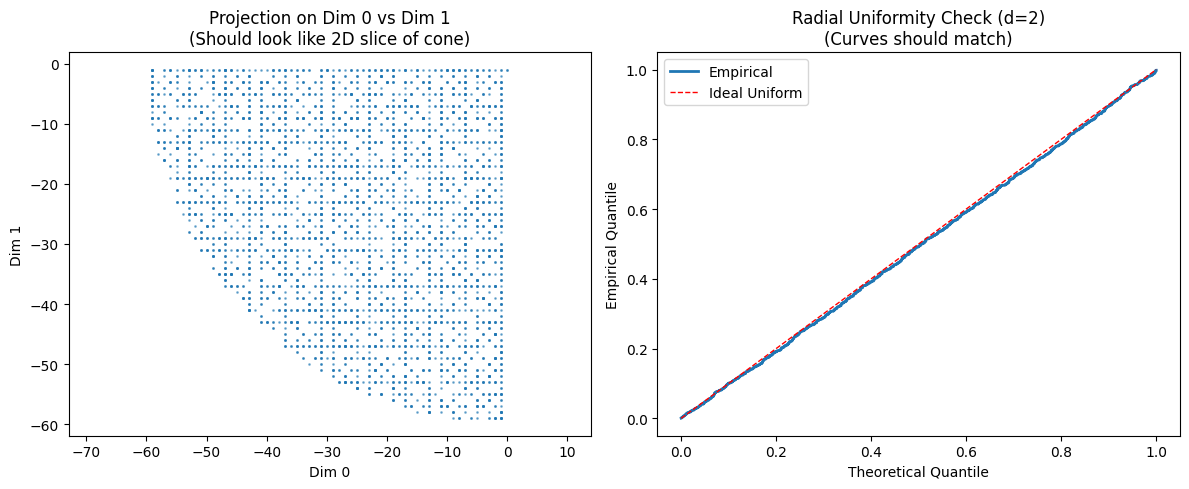

In [94]:
verify_samples(points_chrr, A, b, R)

In [85]:
import numpy as np
from math import gcd
from collections import Counter

def vector_gcd(vec):
    """Compute gcd of all coordinates of a vector."""
    g = 0
    for x in vec:
        g = gcd(g, abs(int(x)))
    return g

def validate_samples(points, A=None, b=None, num_shells=20, chi2=True):
    """
    Validate integer vector samples.

    Parameters
    ----------
    points : np.ndarray shape (N, d)
        Integer samples.
    A, b : optional (cone constraints)
    num_shells : number of radial bins to test uniformity
    chi2 : whether to compute chi² statistic (p-value requires SciPy)

    Returns
    -------
    stats : dict with validation metrics
    """

    pts = np.asarray(points)
    N, d = pts.shape

    # ----------------------------------
    # 1. Duplicate statistics
    # ----------------------------------
    tuples = [tuple(row.tolist()) for row in pts]
    counts = Counter(tuples)
    duplicates = sum(c - 1 for c in counts.values())
    unique = len(counts)
    dup_rate = duplicates / N

    # ----------------------------------
    # 2. GCD = 1 checks
    # ----------------------------------
    gcd1_mask = np.array([vector_gcd(row) == 1 for row in pts], dtype=bool)
    gcd1_fraction = np.mean(gcd1_mask)

    # ----------------------------------
    # 3. Cone constraint validation
    # ----------------------------------
    if A is not None and b is not None:
        viol_mask = np.any((A @ pts.T).T > b + 1e-12, axis=1)
        cone_violations = np.sum(viol_mask)
        cone_ok_fraction = 1 - cone_violations / N
    else:
        cone_violations = None
        cone_ok_fraction = None

    # ----------------------------------
    # 4. Radial (shell) uniformity test
    # ----------------------------------
    radii = np.linalg.norm(pts, axis=1)
    r_min, r_max = radii.min(), radii.max()

    bins = np.linspace(r_min, r_max, num_shells + 1)
    hist, _ = np.histogram(radii, bins=bins)

    if chi2:
        # expected proportional to shell volume difference ∝ r^(d-1)
        shell_midpoints = 0.5 * (bins[:-1] + bins[1:])
        expected = shell_midpoints ** (d - 1)
        expected = expected / expected.sum() * N

        chi2_stat = ((hist - expected) ** 2 / (expected + 1e-12)).sum()
        try:
            from scipy.stats import chi2 as chi2dist
            p_value = 1 - chi2dist(df=num_shells - 1).cdf(chi2_stat)
        except Exception:
            p_value = None
    else:
        chi2_stat = None
        p_value = None

    # ----------------------------------
    # 5. Directional bias check (simple proxy)
    # ----------------------------------
    # Normalize directions
    norms = np.linalg.norm(pts, axis=1) + 1e-12
    dirs = pts / norms[:, None]

    # Example heuristic: fraction of points close to coordinate axes
    axis_bias = np.mean(np.max(np.abs(dirs), axis=1) > 0.98)

    return {
        "N": N,
        "d": d,
        "unique": unique,
        "duplicates": duplicates,
        "dup_rate": dup_rate,

        "gcd1_fraction": gcd1_fraction,

        "cone_ok_fraction": cone_ok_fraction,
        "cone_violations": cone_violations,

        "mean_radius": float(radii.mean()),
        "min_radius": float(radii.min()),
        "max_radius": float(radii.max()),

        "shell_histogram": hist,
        "chi2_stat": chi2_stat,
        "chi2_p_value": p_value,

        "axis_bias_fraction": axis_bias,
    }


In [87]:
validate_samples(points_chrr, A, b, 20, chi2=True)

{'N': 5000,
 'd': 11,
 'unique': 4943,
 'duplicates': 57,
 'dup_rate': 0.0114,
 'gcd1_fraction': np.float64(1.0),
 'cone_ok_fraction': np.float64(1.0),
 'cone_violations': np.int64(0),
 'mean_radius': 4.494954729386352,
 'min_radius': 2.23606797749979,
 'max_radius': 5.0,
 'shell_histogram': array([   1,    3,    7,    0,   14,   25,   28,   42,   59,   85,  124,
         150,  200,  266,  344,  397, 1007,  562,  550, 1136]),
 'chi2_stat': np.float64(881.9918416057814),
 'chi2_p_value': np.float64(0.0),
 'axis_bias_fraction': np.float64(0.0)}

In [1]:
radius_for_N(500,11)

NameError: name 'radius_for_N' is not defined

In [2]:
import sympy as sp

In [25]:
x, y, z, w = sp.symbols('x y z w')
exp = -2*x + 3*z + 4 *y + 1
exp.as_ordered_terms()

[-2*x, 4*y, 3*z, 1]

In [26]:
exp.as_coeff_Mul()

(1, -2*x + 4*y + 3*z + 1)

In [27]:
sp.Poly(exp, [x, y, z]).coeffs()

[-2, 4, 3, 1]

In [28]:
exp.as_coefficients_dict()

defaultdict(int, {1: 1, x: -2, z: 3, y: 4})